# Task 3: Daily News Sentiment vs Daily Stock Returns Correlation

In [14]:
import sys, json, os, math, warnings
from datetime import datetime
import numpy as np
import pandas as pd
from textblob import TextBlob
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
np.random.seed(42)

VERSIONS = {
    'python': sys.version.split()[0],
    'pandas': pd.__version__,
    'numpy': np.__version__,
    'textblob': TextBlob.__module__,
}
print('Library versions:', json.dumps(VERSIONS, indent=2))

Library versions: {
  "python": "3.13.7",
  "pandas": "2.3.3",
  "numpy": "2.3.5",
  "textblob": "textblob.blob"
}


## Configuration & Paths
Adjust ticker or window sizes here without modifying downstream cells.

In [15]:
# Configuration dictionary
CURRENT_TICKER = "META"
CFG = {
    'news_path': '../data/cleaned_ratings.csv',
    'stock_path': f"../data/{CURRENT_TICKER}_task2_price_indicators.csv",
    'headline_col': 'headline',
    'news_datetime_col': 'date',
    'stock_date_col': 'Date',
    'stock_close_col': 'Close',
    'rolling_corr_window': 60,  # days
    'lag_days': [1, 2, 3],
    'output_dir': '../data',
    'fig_dpi': 110,
}


os.makedirs(CFG['output_dir'], exist_ok=True)
print('Configuration loaded.')

Configuration loaded.


## Helper Functions

In [16]:
def load_csv_safe(path, parse_dates=None, ticker=None):
    if not os.path.exists(path):
        raise FileNotFoundError(f'Missing file: {path}')
    df = pd.read_csv(path)
    if "stock" in df.columns:
        df = df[df["stock"] == ticker]
    if "ticker" in df.columns:
        df = df[df["ticker"] == ticker]
    df[parse_dates] = pd.to_datetime(df[parse_dates], errors="coerce").dt.normalize()
    df[parse_dates] = (df[parse_dates].dt.tz_localize(None).dt.normalize())

    return df

def validate_columns(df, required, df_name):
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f'{df_name} missing required columns: {missing}')

def compute_headline_sentiment(text):
    if not isinstance(text, str) or not text.strip():
        return np.nan
    return TextBlob(text).sentiment.polarity  # [-1,1]

def classify_sentiment(p):
    if pd.isna(p):
        return 'neutral'
    if p > 0.05:
        return 'positive'
    if p < -0.05:
        return 'negative'
    return 'neutral'

def interpretation_scale(r):
    ar = abs(r)
    if ar < 0.2: return 'very weak'
    if ar < 0.4: return 'weak'
    if ar < 0.6: return 'moderate'
    if ar < 0.8: return 'strong'
    return 'very strong'

def safe_return_series(close):
    return close.pct_change().replace([np.inf, -np.inf], np.nan)

def lagged_correlation(df, sentiment_col, return_col, max_lag_list):
    results = []
    for lag in max_lag_list:
        shifted = df[[sentiment_col, return_col]].copy()
        shifted[return_col] = shifted[return_col].shift(-lag)  # forward looking return vs today's sentiment
        valid = shifted.dropna()
        if len(valid) < 5:
            results.append({'lag_days': lag, 'pearson_r': np.nan, 'pearson_p': np.nan, 'spearman_r': np.nan, 'spearman_p': np.nan, 'n': len(valid)})
            continue
        pr, pp = pearsonr(valid[sentiment_col], valid[return_col])
        sr, sp = spearmanr(valid[sentiment_col], valid[return_col])
        results.append({'lag_days': lag, 'pearson_r': pr, 'pearson_p': pp, 'spearman_r': sr, 'spearman_p': sp, 'n': len(valid)})
    return pd.DataFrame(results)

print('Helper functions defined.')

Helper functions defined.


## 1. Load Data from previous tasks

In [17]:
news_df = load_csv_safe(CFG['news_path'], parse_dates=CFG['news_datetime_col'], ticker="FB")
stock_df = load_csv_safe(CFG['stock_path'], parse_dates=CFG['stock_date_col'], ticker=CURRENT_TICKER)

print('News rows:', len(news_df))
print('Stock rows:', len(stock_df))
news_df.tail(2), stock_df.tail(2)

News rows: 380
Stock rows: 2923


(        Unnamed: 0                                           headline  \
 474251      476819  Bloomberg Pays People To Promote His Campaign ...   
 474252      476820  Calendar Apps Can Do Wonders And Not Only For ...   
 
                                                       url      publisher  \
 474251  https://www.benzinga.com/news/20/02/15371694/b...  Neer Varshney   
 474252  https://www.benzinga.com/news/20/02/15364635/c...   IAM Newswire   
 
              date stock  headline_len_chars  headline_len_words  
 474251 2020-02-19    FB                  76                  12  
 474252 2020-02-19    FB                  59                  11  ,
            Date       Close        High         Low        Open    Volume  \
 2921 2023-12-28  356.124634  359.682686  355.617749  357.496184  11798800   
 2922 2023-12-29  351.791290  357.794292  349.664418  356.790470  14987100   
 
        TA_SMA_20   TA_EMA_20  TA_RSI_14   TA_MACD  TA_MACD_signal  \
 2921  335.537503  340.597473  70.2

## 2. Validation & Date Normalization
- Ensure required columns present.
- Normalize news timestamps to dates.
- Map weekend news to next business day

In [18]:
validate_columns(news_df, [CFG['news_datetime_col'], CFG['headline_col']], 'news_df')
validate_columns(stock_df, [CFG['stock_date_col'], CFG['stock_close_col']], 'stock_df')

# Normalize dates
news_df['original_datetime'] = news_df[CFG['news_datetime_col']]
news_df['date'] = news_df[CFG['news_datetime_col']].dt.normalize()

# Weekend mapping: Saturday(5)/Sunday(6) -> next business day
weekend_mask = news_df['date'].dt.weekday >= 5
news_df.loc[weekend_mask, 'date'] = news_df.loc[weekend_mask, 'date'] + pd.offsets.BDay(1)

# Stock trading date normalization
stock_df['date'] = stock_df[CFG['stock_date_col']].dt.normalize()

print('Date ranges:')
print('News:', news_df['date'].min(), '->', news_df['date'].max())
print('Stock:', stock_df['date'].min(), '->', stock_df['date'].max())

overlap_dates = set(news_df['date']).intersection(set(stock_df['date']))
print('Overlap trading days:', len(overlap_dates))

Date ranges:
News: 2020-02-19 00:00:00 -> 2020-06-10 00:00:00
Stock: 2012-05-18 00:00:00 -> 2023-12-29 00:00:00
Overlap trading days: 74


## 3. Per-Headline Sentiment Scoring

In [19]:
news_df['sentiment'] = news_df[CFG['headline_col']].apply(compute_headline_sentiment)
news_df['sentiment_class'] = news_df['sentiment'].apply(classify_sentiment)

nan_ratio = news_df['sentiment'].isna().mean() * 100
print(f'NaN sentiment ratio: {nan_ratio:.3f}%')
print('Sentiment summary:')
print(news_df['sentiment'].describe())
print(news_df['sentiment_class'].value_counts(normalize=True).rename('proportion'))

NaN sentiment ratio: 0.000%
Sentiment summary:
count    380.000000
mean       0.052653
std        0.195747
min       -0.800000
25%        0.000000
50%        0.000000
75%        0.067045
max        1.000000
Name: sentiment, dtype: float64
sentiment_class
neutral     0.613158
positive    0.268421
negative    0.118421
Name: proportion, dtype: float64


## 4. Daily Sentiment Aggregation
Metrics per trading date:
- mean_sentiment
- sentiment_count (number of headlines)
- sentiment_std (volatility of sentiment)
- sentiment_pos_ratio / neg_ratio / neutral_ratio

In [20]:
daily_sent = (
    news_df.groupby('date').agg(
        mean_sentiment=('sentiment', 'mean'),
        sentiment_count=('sentiment', 'count'),
        sentiment_std=('sentiment', 'std')
    ).reset_index()
)

# Add class proportions
class_pivot = (
    news_df.pivot_table(index='date', columns='sentiment_class', values='sentiment', aggfunc='count').fillna(0)
)
class_pivot = class_pivot.div(class_pivot.sum(axis=1), axis=0).add_prefix('ratio_')
daily_sent = daily_sent.merge(class_pivot.reset_index(), on='date', how='left')

print('Daily sentiment head:')
daily_sent.head()

Daily sentiment head:


,date,mean_sentiment,sentiment_count,sentiment_std,ratio_negative,ratio_neutral,ratio_positive
0,2020-02-19,0.008333,2,0.011785,0.00,1.000000,0.000000
1,2020-02-20,0.025000,2,0.035355,0.00,0.500000,0.500000
2,2020-02-21,-0.112500,4,0.193111,0.25,0.750000,0.000000
3,2020-02-24,0.035000,5,0.078262,0.00,0.800000,0.200000
4,2020-02-25,0.045455,3,0.078730,0.00,0.666667,0.333333


## 5. Daily Stock Returns
Compute arithmetic percent change from close prices. If already present, recompute to ensure consistency.

In [21]:
stock_df = stock_df.sort_values('date')
stock_df['daily_return'] = safe_return_series(stock_df[CFG['stock_close_col']])
stock_df['cumulative_return'] = (1 + stock_df['daily_return']).cumprod() - 1

print('Stock return summary:')
print(stock_df['daily_return'].describe())

Stock return summary:
count    2922.000000
mean        0.001082
std         0.025280
min        -0.263901
25%        -0.010045
50%         0.000998
75%         0.012825
max         0.296115
Name: daily_return, dtype: float64


## 6. Merge Sentiment & Returns

In [22]:
merged = stock_df[['date', 'daily_return', 'cumulative_return']].merge(daily_sent, on='date', how='inner')
merged = merged.sort_values('date')
print('Merged rows:', len(merged))
merged.head()

Merged rows: 74


,date,daily_return,cumulative_return,mean_sentiment,sentiment_count,sentiment_std,ratio_negative,ratio_neutral,ratio_positive
0,2020-02-19,-0.001423,4.688989,0.008333,2,0.011785,0.00,1.000000,0.000000
1,2020-02-20,-0.013380,4.612870,0.025000,2,0.035355,0.00,0.500000,0.500000
2,2020-02-21,-0.020505,4.497777,-0.112500,4,0.193111,0.25,0.750000,0.000000
3,2020-02-24,-0.045009,4.250328,0.035000,5,0.078262,0.00,0.800000,0.200000
4,2020-02-25,-0.019679,4.147006,0.045455,3,0.078730,0.00,0.666667,0.333333


## 7. Correlation & Lag Analysis
Includes:
- Pearson r + p-value
- Spearman rho + p-value
- Rolling Pearson correlation (window = 60 days)
- Lagged correlations (sentiment leading returns by 1–3 days)

In [23]:
corr_df = merged.dropna(subset=['mean_sentiment', 'daily_return'])
pearson_r, pearson_p = pearsonr(corr_df['mean_sentiment'], corr_df['daily_return']) if len(corr_df) > 1 else (np.nan, np.nan)
spearman_r, spearman_p = spearmanr(corr_df['mean_sentiment'], corr_df['daily_return']) if len(corr_df) > 1 else (np.nan, np.nan)

# Rolling correlation
merged['rolling_corr'] = merged['mean_sentiment'].rolling(CFG['rolling_corr_window']).corr(merged['daily_return'])

# Lag analysis
lag_results = lagged_correlation(merged, 'mean_sentiment', 'daily_return', CFG['lag_days'])

pearson_strength = interpretation_scale(pearson_r)
spearman_strength = interpretation_scale(spearman_r)

print(f'Pearson r={pearson_r:.4f}, p={pearson_p:.4g}, interpretation: {pearson_strength}')
print(f'Spearman rho={spearman_r:.4f}, p={spearman_p:.4g}, interpretation: {spearman_strength}')
print('Lagged correlation results:')
lag_results

Pearson r=0.1740, p=0.1381, interpretation: very weak
Spearman rho=0.1966, p=0.09327, interpretation: very weak
Lagged correlation results:


,lag_days,pearson_r,pearson_p,spearman_r,spearman_p,n
0,1,-0.157428,0.183465,-0.045778,0.700553,73
1,2,0.053105,0.657739,0.058904,0.623073,72
2,3,-0.000166,0.998905,-0.064895,0.590799,71


## 8. Visualization

Saved figure to ../data/META_sentiment_return_plots.png


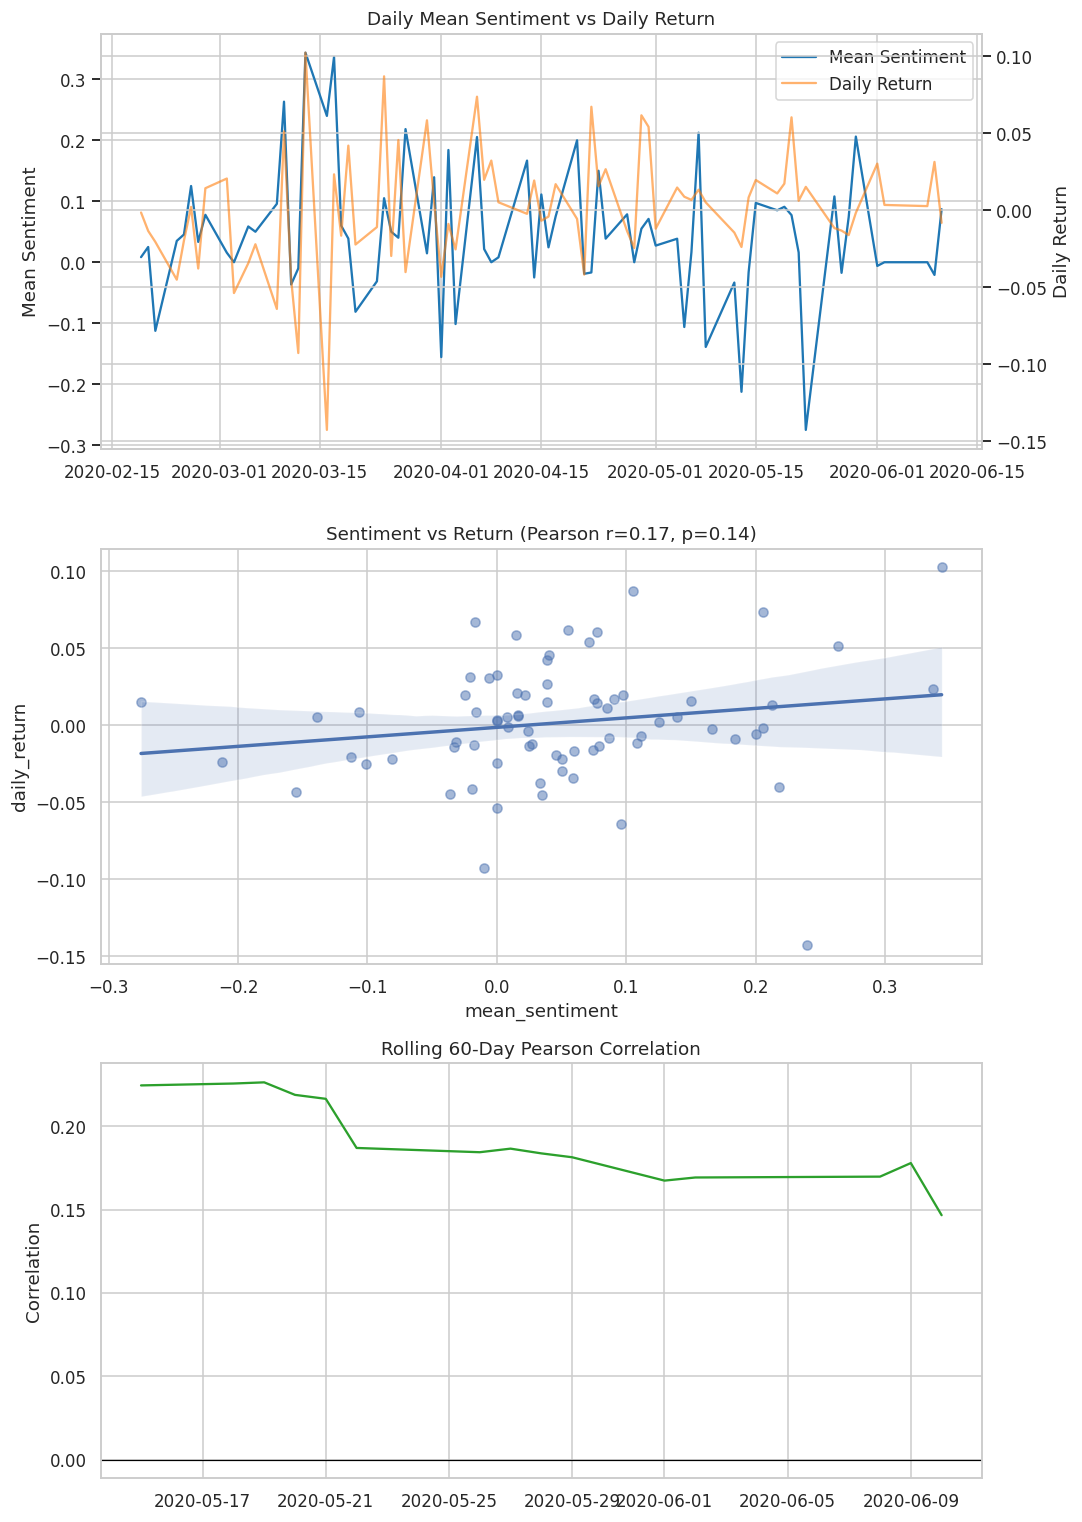

Saved distribution figure to ../data/META_sentiment_distribution.png


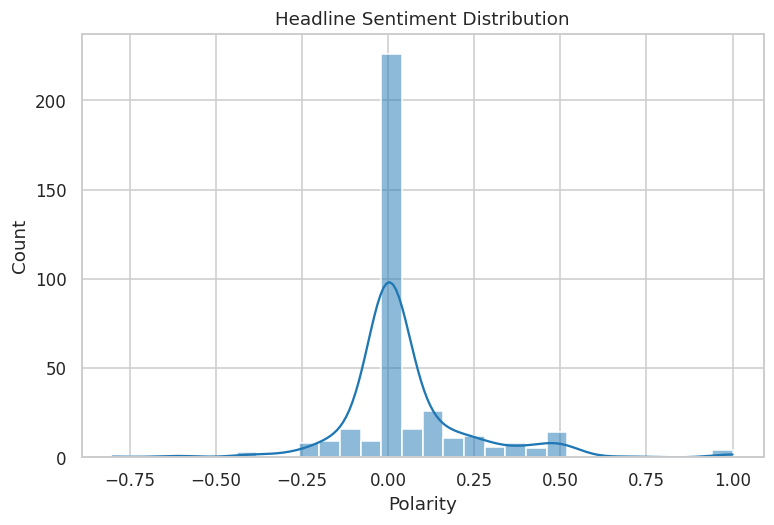

In [24]:
sns.set_theme(style='whitegrid')
fig, axes = plt.subplots(3, 1, figsize=(10, 14), dpi=CFG['fig_dpi'])

# Time series sentiment vs returns
ax = axes[0]
ax2 = ax.twinx()
ax.plot(merged['date'], merged['mean_sentiment'], color='tab:blue', label='Mean Sentiment')
ax2.plot(merged['date'], merged['daily_return'], color='tab:orange', alpha=0.6, label='Daily Return')
ax.set_title('Daily Mean Sentiment vs Daily Return')
ax.set_ylabel('Mean Sentiment')
ax2.set_ylabel('Daily Return')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper right')

# Scatter plot + regression
ax = axes[1]
sns.regplot(data=corr_df, x='mean_sentiment', y='daily_return', ax=ax, scatter_kws={'alpha':0.5})
ax.set_title(f'Sentiment vs Return (Pearson r={pearson_r:.2f}, p={pearson_p:.2g})')

# Rolling correlation
ax = axes[2]
ax.plot(merged['date'], merged['rolling_corr'], color='tab:green')
ax.axhline(0, color='black', linewidth=0.8)
ax.set_title(f'Rolling {CFG['rolling_corr_window']}-Day Pearson Correlation')
ax.set_ylabel('Correlation')

plt.tight_layout()
fig_path = os.path.join(CFG['output_dir'], f'{CURRENT_TICKER}_sentiment_return_plots.png')
plt.savefig(fig_path)
print('Saved figure to', fig_path)
plt.show()

# Sentiment distribution
plt.figure(figsize=(8,5), dpi=CFG['fig_dpi'])
sns.histplot(news_df['sentiment'], bins=30, kde=True, color='tab:blue')
plt.title('Headline Sentiment Distribution')
plt.xlabel('Polarity')
dist_path = os.path.join(CFG['output_dir'], f'{CURRENT_TICKER}_sentiment_distribution.png')
plt.savefig(dist_path)
print('Saved distribution figure to', dist_path)
plt.show()

## 9. Save Artifacts (Data & Metrics)

In [25]:
merged_path = os.path.join(CFG['output_dir'], f'{CURRENT_TICKER}_daily_sentiment_returns.csv')
merged.to_csv(merged_path, index=False)

metrics = {
    'rows_merged': int(len(merged)),
    'pearson_r': float(pearson_r),
    'pearson_p': float(pearson_p),
    'pearson_strength': pearson_strength,
    'spearman_r': float(spearman_r),
    'spearman_p': float(spearman_p),
    'spearman_strength': spearman_strength,
    'lag_results': lag_results.to_dict(orient='records'),
    'window': CFG['rolling_corr_window'],
    'date_range': {
        'start': str(merged['date'].min().date()) if len(merged) else None,
        'end': str(merged['date'].max().date()) if len(merged) else None
    },
    'version_info': VERSIONS
}

metrics_path = os.path.join(CFG['output_dir'], f'{CURRENT_TICKER}_correlation_metrics.json')
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)

print('Saved merged dataset ->', merged_path)
print('Saved metrics ->', metrics_path)

Saved merged dataset -> ../data/META_daily_sentiment_returns.csv
Saved metrics -> ../data/META_correlation_metrics.json
